In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns

from glob import glob
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import threshold_img
from nilearn.glm import threshold_stats_img

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
from nilearn.masking import apply_mask
from scipy import stats

In [3]:
from nilearn import plotting, datasets, surface

# for plotting slices
mni152_template = datasets.load_mni152_template(resolution=1)
# for plotting on surface
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [4]:
task_label = 'tonecat'
contrast_label = 'sound'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'

# define data directories
bidsroot = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                        'FLT/',
                        'data_denoised', #'data_bids'
                       )
nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
masks_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                         'FLT/', 'data_bids', 'derivatives', 'nilearn', 'masks')
# define first-level directory where group-level inputs will be pulled from
l1_dir = os.path.join(nilearn_dir, 'level-1_fwhm-%.02f'%fwhm)

# create output directory
group_out_dir = os.path.join(nilearn_dir, 'group_fwhm-%.02f'%fwhm)
if not os.path.exists(group_out_dir):
        os.makedirs(group_out_dir)

# Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [5]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # always leave out FLT27 – did not participate
               #'sub-FLT02', 'sub-FLT04', 'sub-FLT18', 'sub-FLT19', # currently reprocessing
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [6]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT07   22   M      Mandarin  2003.0
6       sub-FLT08   23   F      Mandarin  2005.0
7       sub-FLT09   30   F  non-Mandarin  3002.0
8       sub-FLT10   23   F      Mandarin  2006.0
9       sub-FLT11   20   F  non-Mandarin  1005.0
10      sub-FLT12   20   F  non-Mandarin  3004.0
11      sub-FLT13   23   F  non-Mandarin  3005.0
12      sub-FLT14   23   M  non-Mandarin  3006.0
13      sub-FLT15   22   M      Mandarin  2010.0
14      sub-FLT17   29   F      Mandarin     NaN
15      sub-FLT18   24   M      Mandarin  2016.0
16      sub-FLT19   24   M      Mandarin  2018.0
17      sub-FLT20   26   F  non-Mandarin  3008.0
18      sub-FLT21   21   M      Mandarin  2011.0
19      sub-FLT22   

In [7]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [8]:
print(sub_list_mand)

['sub-FLT03', 'sub-FLT05', 'sub-FLT07', 'sub-FLT08', 'sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT19', 'sub-FLT21', 'sub-FLT22', 'sub-FLT23', 'sub-FLT24', 'sub-FLT26']


In [9]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25', 'sub-FLT28', 'sub-FLT30']


#### Create design matrixes

In [10]:
# get participant IDs and their group labels
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)

# make new dataframe from the group labels
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )
# convert to 1s and 0s for each group as appropriate
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      1     0
4      0     1
5      1     0
6      1     0
7      0     1
8      1     0
9      0     1
10     0     1
11     0     1
12     0     1
13     1     0
14     1     0
15     1     0
16     1     0
17     0     1
18     1     0
19     1     0
20     1     0
21     1     0
22     0     1
23     1     0
24     0     1
25     0     1


### Define regions

In [11]:
'''
roi_dict_MNI_dseg = {'L-HG': 189, 'L-PP': 187, 
                     'L-PT': 191, 'L-STGa': 117, 'L-STGp': 119, 
                     'L-ParsOp': 111, 'L-ParsTri': 109, 
                     'R-HG': 190, 'R-PP': 188, 
                     'R-PT': 192, 'R-STGa': 118, 'R-STGp': 120, 
                     'R-ParsOp': 112, 'R-ParsTri': 110, 
                    }

roi_dict_MNI_sg_subcort = {'L-CN': 1, 'L-SOC': 3, 'L-IC': 5, 'L-MGN': 7, 
                           'R-CN': 2, 'R-SOC': 4, 'R-IC': 6, 'R-MGN': 8, }
region_list = list(roi_dict_MNI_sg_subcort.keys()) + list(roi_dict_MNI_dseg.keys())
'''
region_list = ['L-IC', 'L-MGN', 'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
               'R-IC', 'R-MGN', 'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', ]

In [12]:
print(region_list)

['L-IC', 'L-MGN', 'L-HG', 'L-PT', 'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri', 'R-IC', 'R-MGN', 'R-HG', 'R-PT', 'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri']


## Across all runs

### Get files

In [13]:
# get the beta map for the contrast of interest for each subject
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in subjects_label]

In [14]:
l1_fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]
l1_fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

## Mask stat maps

In [15]:
roi_mean_dict = {}
for rx, region in enumerate(region_list):
    print(region)
    roi_mean_list = []
    
    for fx, stat_fpath in enumerate(l1_fnames_groupdiff):
        sub_id = subjects_label[fx]
        mask_fpath = glob(masks_dir + f'/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]
        
        masked_data = apply_mask(stat_fpath, mask_fpath)
        roi_mean_sub = masked_data.mean()
        
        roi_mean_list.append(roi_mean_sub)
        
    roi_mean_dict[region] = roi_mean_list

L-IC
L-MGN
L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-IC
R-MGN
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [16]:
roi_df = pd.DataFrame.from_dict(roi_mean_dict)

roi_df['participant_id'] = participants_df.participant_id
roi_df['participant_group'] = participants_df.group

In [17]:
roi_df_long = roi_df.melt(id_vars=["participant_id", "participant_group"], 
                          var_name="region", value_name="beta")

In [18]:
roi_df_long

,participant_id,participant_group,region,beta
0,sub-FLT02,non-Mandarin,L-IC,0.443150
1,sub-FLT03,Mandarin,L-IC,7.441238
2,sub-FLT04,non-Mandarin,L-IC,-2.258574
3,sub-FLT05,Mandarin,L-IC,6.917255
4,sub-FLT06,non-Mandarin,L-IC,-0.574357
...,...,...,...,...
463,sub-FLT24,Mandarin,R-ParsTri,-4.052011
464,sub-FLT25,non-Mandarin,R-ParsTri,-0.399761
465,sub-FLT26,Mandarin,R-ParsTri,0.973845
466,sub-FLT28,non-Mandarin,R-ParsTri,-2.918352


### split hemisphere into its own column

In [19]:
roi_df_long['hemisphere'] = roi_df_long.region.str[0]
roi_df_long['region'] = roi_df_long.region.str[2:]

### Compare groups

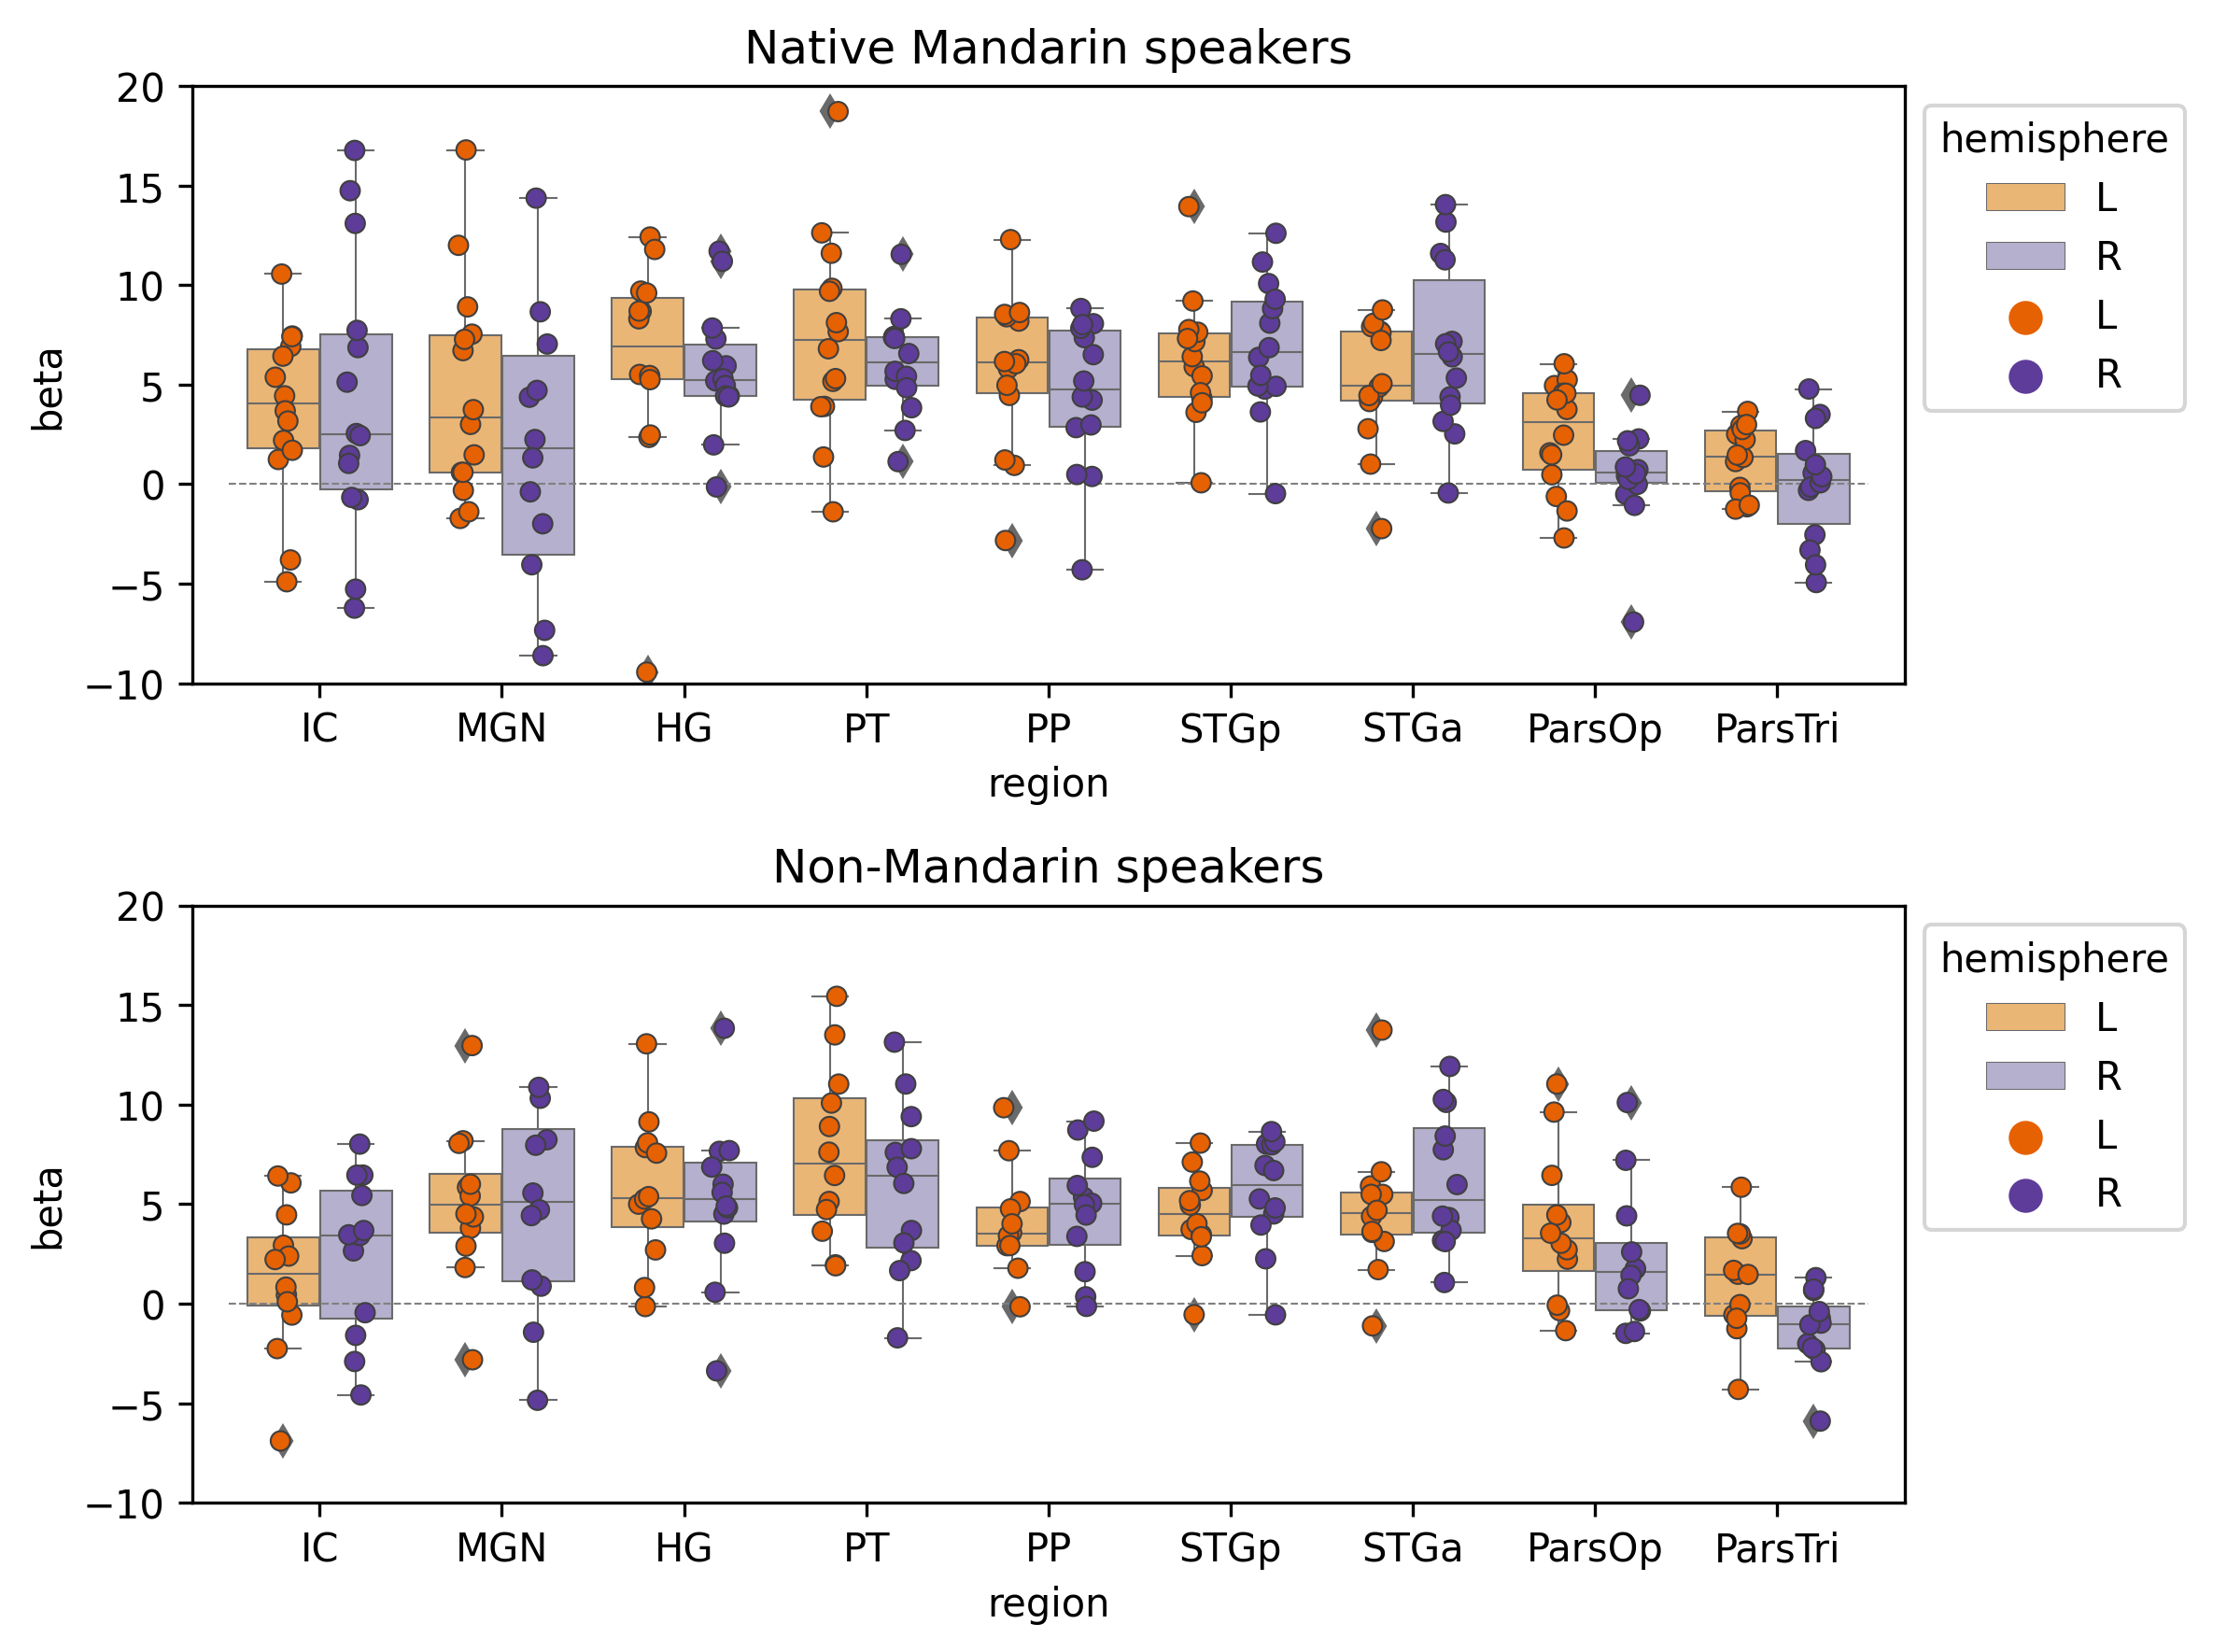

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)
yrange = [-10, 20]
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[0]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[0]);
xmin, xmax = ax[0].get_xlim()
ax[0].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[0].set_ylim(yrange)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('Native Mandarin speakers');

sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[1]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[1]);
xmin, xmax = ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[1].set_ylim(yrange)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[1].set_title('Non-Mandarin speakers');

fig.tight_layout()


### all participants

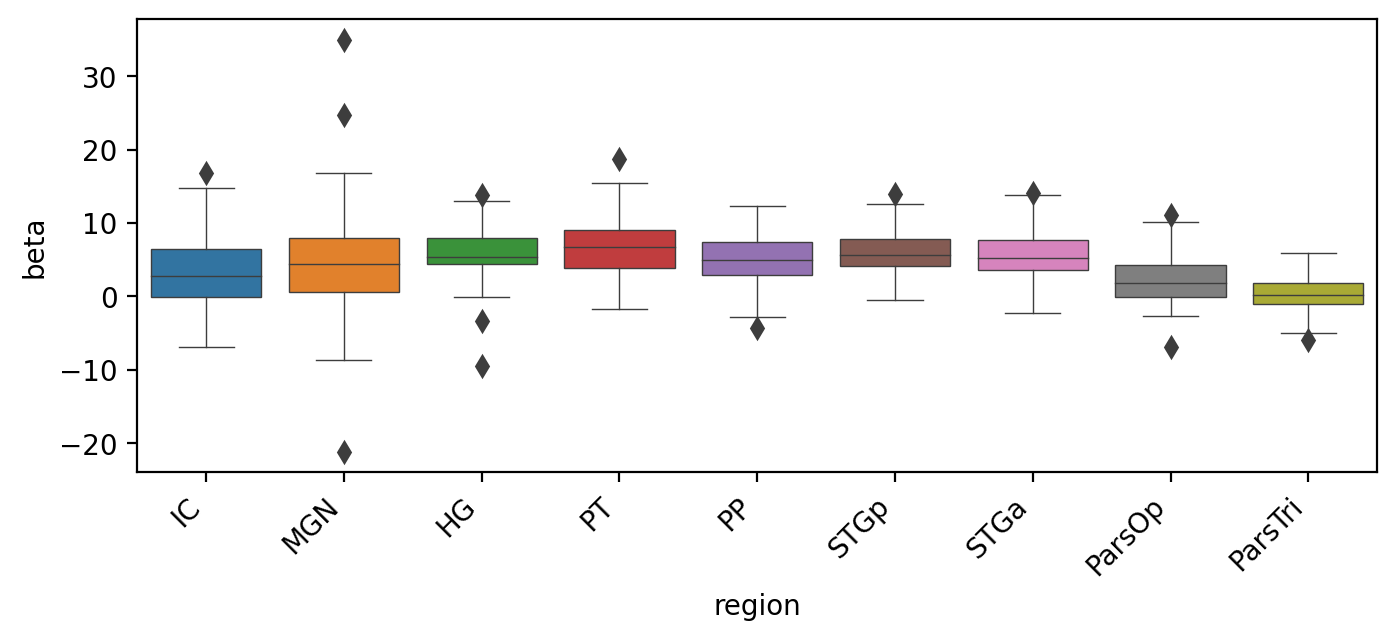

In [21]:
fig, ax = plt.subplots(figsize=(8,3), dpi=200)
sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              #hue='participant_group',
              #palette=['#0571b0','#ca0020'],
              #dodge=True,
              linewidth=0.5,
              ax=ax);
plt.xticks(rotation=45, ha='right');
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Statistics

#### Group differences

In [22]:
p_vals = []
t_stats = []
for roi in region_list:
    mand_data = roi_df.where(roi_df.participant_group=='Mandarin').dropna()[roi]
    nman_data = roi_df.where(roi_df.participant_group=='non-Mandarin').dropna()[roi]
    res = stats.ttest_ind(mand_data, nman_data)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

t = 1.49 p = 0.7171 region = L-IC
t = -0.23 p = 0.9468 region = L-MGN
t = 0.22 p = 0.9468 region = L-HG
t = -0.08 p = 0.9468 region = L-PT
t = 1.18 p = 0.7171 region = L-PP
t = 1.61 p = 0.7171 region = L-STGp
t = 0.27 p = 0.9468 region = L-STGa
t = -1.02 p = 0.7171 region = L-ParsOp
t = 0.07 p = 0.9468 region = L-ParsTri
t = 0.74 p = 0.9315 region = R-IC
t = -1.26 p = 0.7171 region = R-MGN
t = 0.41 p = 0.9468 region = R-HG
t = 0.12 p = 0.9468 region = R-PT
t = -0.15 p = 0.9468 region = R-PP
t = 1.09 p = 0.7171 region = R-STGp
t = 0.45 p = 0.9468 region = R-STGa
t = -1.51 p = 0.7171 region = R-ParsOp
t = 1.33 p = 0.7171 region = R-ParsTri


#### Within-group significance

In [23]:
for group in np.unique(roi_df.participant_group):
    p_vals = []
    t_stats = []
    print(f'group = {group}')
    for roi in region_list:
        groi_data = roi_df.where(roi_df.participant_group==group).dropna()[roi]
        res = stats.ttest_1samp(groi_data, popmean=0)
        #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
    p_vals_adj = stats.false_discovery_control(p_vals)
    for rx, roi in enumerate(region_list):
        if p_vals_adj[rx] < 0.05:
            ast = '*'
        else:
            ast = ' '
        print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

group = Mandarin
*t = 3.23 p = 0.0098 region = L-IC
*t = 3.19 p = 0.0098 region = L-MGN
*t = 4.22 p = 0.0018 region = L-HG
*t = 5.46 p = 0.0002 region = L-PT
*t = 5.50 p = 0.0002 region = L-PP
*t = 7.35 p = 0.0000 region = L-STGp
*t = 6.17 p = 0.0001 region = L-STGa
*t = 3.40 p = 0.0078 region = L-ParsOp
*t = 2.63 p = 0.0268 region = L-ParsTri
 t = 2.24 p = 0.0516 region = R-IC
 t = 0.58 p = 0.6026 region = R-MGN
*t = 6.88 p = 0.0001 region = R-HG
*t = 8.83 p = 0.0000 region = R-PT
*t = 4.47 p = 0.0013 region = R-PP
*t = 7.56 p = 0.0000 region = R-STGp
*t = 6.03 p = 0.0001 region = R-STGa
 t = 0.61 p = 0.6026 region = R-ParsOp
 t = -0.01 p = 0.9952 region = R-ParsTri
group = non-Mandarin
 t = 1.26 p = 0.2330 region = L-IC
*t = 4.58 p = 0.0014 region = L-MGN
*t = 5.40 p = 0.0006 region = L-HG
*t = 5.95 p = 0.0004 region = L-PT
*t = 5.45 p = 0.0006 region = L-PP
*t = 6.77 p = 0.0003 region = L-STGp
*t = 4.70 p = 0.0013 region = L-STGa
*t = 3.47 p = 0.0079 region = L-ParsOp
 t = 1.46 p = 

#### all participants

In [24]:
p_vals = []
t_stats = []
print(f'group = all')
for roi in region_list:
    groi_data = roi_df.dropna()[roi]
    res = stats.ttest_1samp(groi_data, popmean=0)
    #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(region_list):
    if p_vals_adj[rx] < 0.05:
        ast = '*'
    else:
        ast = ' '
    print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

group = all
*t = 3.24 p = 0.0047 region = L-IC
*t = 5.27 p = 0.0000 region = L-MGN
*t = 6.56 p = 0.0000 region = L-HG
*t = 8.14 p = 0.0000 region = L-PT
*t = 7.50 p = 0.0000 region = L-PP
*t = 9.56 p = 0.0000 region = L-STGp
*t = 7.81 p = 0.0000 region = L-STGa
*t = 4.82 p = 0.0001 region = L-ParsOp
*t = 2.75 p = 0.0130 region = L-ParsTri
*t = 3.01 p = 0.0075 region = R-IC
 t = 1.97 p = 0.0641 region = R-MGN
*t = 7.82 p = 0.0000 region = R-HG
*t = 9.00 p = 0.0000 region = R-PT
*t = 6.94 p = 0.0000 region = R-PP
*t = 10.18 p = 0.0000 region = R-STGp
*t = 8.70 p = 0.0000 region = R-STGa
 t = 2.04 p = 0.0580 region = R-ParsOp
 t = -1.23 p = 0.2315 region = R-ParsTri


## Early vs. late runs

In [25]:
# get the beta map for the contrast of interest for each subject
l1_fnames_firsthalf = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/firsthalf/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in subjects_label]
l1_fnames_secondhalf = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/secondhalf/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in subjects_label]

#l1_fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]
#l1_fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/grouped_runs/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

In [26]:
l1_fnames_firsthalf

['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/grouped_runs/firsthalf/sub-FLT02_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/grouped_runs/firsthalf/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/grouped_runs/firsthalf/sub-FLT04_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/grouped_runs/firsthalf/sub-FLT05_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz',
 '/bgfs/bchandrasekaran/krs2

## Mask stat maps

In [27]:
roi_firsthalf_mean_dict = {}
roi_secondhalf_mean_dict = {}
for rx, region in enumerate(region_list):
    print(region)
    
    roi_firsthalf_mean_list = []
    for fx, stat_fpath in enumerate(l1_fnames_firsthalf):
        sub_id = subjects_label[fx]
        mask_fpath = glob(nilearn_dir + f'/masks/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]
        
        masked_data = apply_mask(stat_fpath, mask_fpath)
        roi_mean_sub = masked_data.mean()
        
        roi_firsthalf_mean_list.append(roi_mean_sub)
        
    roi_firsthalf_mean_dict[region] = roi_firsthalf_mean_list
    
    roi_secondhalf_mean_list = []
    for fx, stat_fpath in enumerate(l1_fnames_secondhalf):
        sub_id = subjects_label[fx]
        mask_fpath = glob(nilearn_dir + f'/masks/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]
        
        masked_data = apply_mask(stat_fpath, mask_fpath)
        roi_mean_sub = masked_data.mean()
        
        roi_secondhalf_mean_list.append(roi_mean_sub)
        
    roi_secondhalf_mean_dict[region] = roi_secondhalf_mean_list

L-IC


IndexError: list index out of range

In [ ]:
roi_firsthalf_df = pd.DataFrame.from_dict(roi_firsthalf_mean_dict)
roi_secondhalf_df = pd.DataFrame.from_dict(roi_secondhalf_mean_dict)


roi_firsthalf_df['participant_id'] = participants_df.participant_id
roi_firsthalf_df['participant_group'] = participants_df.group
roi_secondhalf_df['participant_id'] = participants_df.participant_id
roi_secondhalf_df['participant_group'] = participants_df.group

In [ ]:
roi_firsthalf_df

In [ ]:
roi_secondhalf_df

In [ ]:
roi_firsthalf_df_long = roi_firsthalf_df.melt(id_vars=["participant_id", "participant_group", ], 
                                              var_name="region", value_name="beta")
roi_firsthalf_df_long['data_split'] = 'first_half'

roi_secondhalf_df_long = roi_secondhalf_df.melt(id_vars=["participant_id", "participant_group"], 
                                               var_name="region", value_name="beta")
roi_secondhalf_df_long['data_split'] = 'second_half'

roi_firsthalf_df_long['hemisphere'] = roi_firsthalf_df_long.region.str[0]
roi_firsthalf_df_long['region'] = roi_firsthalf_df_long.region.str[2:]

roi_secondhalf_df_long['hemisphere'] = roi_secondhalf_df_long.region.str[0]
roi_secondhalf_df_long['region'] = roi_secondhalf_df_long.region.str[2:]



In [ ]:
roi_df_long = pd.concat([roi_firsthalf_df_long, roi_secondhalf_df_long],)


In [ ]:
roi_df_long

### Compare groups

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)
fig.suptitle('First half')

sns.boxplot(data=roi_df_long.where(roi_firsthalf_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[0]);
sns.stripplot(data=roi_df_long.where(roi_firsthalf_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[0]);
xmin, xmax = ax[0].get_xlim()
ax[0].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('Native Mandarin speakers');

sns.boxplot(data=roi_df_long.where(roi_firsthalf_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[1]);
sns.stripplot(data=roi_df_long.where(roi_firsthalf_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[1]);
xmin, xmax = ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[1].set_title('Non-Mandarin speakers');

fig.tight_layout()


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)
fig.suptitle('Second half')

sns.boxplot(data=roi_df_long.where(roi_secondhalf_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[0]);
sns.stripplot(data=roi_df_long.where(roi_secondhalf_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[0]);
xmin, xmax = ax[0].get_xlim()
ax[0].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('Native Mandarin speakers');

sns.boxplot(data=roi_df_long.where(roi_secondhalf_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[1]);
sns.stripplot(data=roi_df_long.where(roi_secondhalf_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[1]);
xmin, xmax = ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#plt.xticks(rotation=45, ha='right');
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[1].set_title('Non-Mandarin speakers');

fig.tight_layout()


### all participants

In [ ]:
fig, ax = plt.subplots(figsize=(8,3), dpi=200)
fig.suptitle('First half')
sns.boxplot(data=roi_firsthalf_df_long, 
              x='region', y='beta', 
              #hue='participant_group',
              #palette=['#0571b0','#ca0020'],
              #dodge=True,
              linewidth=0.5,
              ax=ax);
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45, ha='right');
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
fig, ax = plt.subplots(figsize=(8,3), dpi=200)
fig.suptitle('Second half')
sns.boxplot(data=roi_secondhalf_df_long, 
              x='region', y='beta', 
              #hue='participant_group',
              #palette=['#0571b0','#ca0020'],
              #dodge=True,
              linewidth=0.5,
              ax=ax);
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right');
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Statistics

#### Within-group differences between halves

In [ ]:
p_vals = []
t_stats = []
print('Native Mandarin, first half vs. second half')
for roi in region_list:
    data1 = roi_firsthalf_df.where(roi_firsthalf_df.participant_group=='Mandarin').dropna()[roi]
    data2 = roi_secondhalf_df.where(roi_secondhalf_df.participant_group=='Mandarin').dropna()[roi]
    res = stats.ttest_ind(data1, data2)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

In [ ]:
p_vals = []
t_stats = []
print('Non-Mandarin, first half vs. second half')
for roi in region_list:
    data1 = roi_firsthalf_df.where(roi_firsthalf_df.participant_group=='non-Mandarin').dropna()[roi]
    data2 = roi_secondhalf_df.where(roi_secondhalf_df.participant_group=='non-Mandarin').dropna()[roi]
    res = stats.ttest_ind(data1, data2)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

In [ ]:
p_vals

#### Group differences

In [ ]:
p_vals = []
t_stats = []
print('First half')
for roi in region_list:
    mand_data = roi_firsthalf_df.where(roi_firsthalf_df.participant_group=='Mandarin').dropna()[roi]
    nman_data = roi_firsthalf_df.where(roi_firsthalf_df.participant_group=='non-Mandarin').dropna()[roi]
    res = stats.ttest_ind(mand_data, nman_data)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

In [ ]:
stats.false_discovery_control(p_vals)

In [ ]:
p_vals = []
t_stats = []
print('Second half')
for roi in region_list:
    mand_data = roi_secondhalf_df.where(roi_secondhalf_df.participant_group=='Mandarin').dropna()[roi]
    nman_data = roi_secondhalf_df.where(roi_secondhalf_df.participant_group=='non-Mandarin').dropna()[roi]
    res = stats.ttest_ind(mand_data, nman_data)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')